## Loading needed libs

In [1]:
import json, os, sys, datetime, io, csv,time
import pandas as pd
import numpy as np
from dateutil import relativedelta
import matplotlib.pyplot as plt

## Coronavirus XSL section

In [2]:
corona_xls = pd.ExcelFile("HIST_PAINEL_COVIDBR_01jul2020.xlsx")
df_corona_initial = corona_xls.parse("Sheet 1") 

#### Removing data where there is no City filled (the data comes with Country > State > City level)

In [3]:
df_corona = df_corona_initial[pd.notna(df_corona_initial.municipio)] #kepping the original df in case there are changes below

In [4]:
df_corona.head()

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos,interior/metropolitana
3681,Norte,RO,Alta Floresta D'Oeste,11,110001.0,11005.0,ZONA DA MATA,2020-03-27,13,22945,0,0,0,0,NaN,NaN,0.0
3682,Norte,RO,Alta Floresta D'Oeste,11,110001.0,11005.0,ZONA DA MATA,2020-03-28,13,22945,0,0,0,0,NaN,NaN,0.0
3683,Norte,RO,Alta Floresta D'Oeste,11,110001.0,11005.0,ZONA DA MATA,2020-03-29,14,22945,0,0,0,0,NaN,NaN,0.0
3684,Norte,RO,Alta Floresta D'Oeste,11,110001.0,11005.0,ZONA DA MATA,2020-03-30,14,22945,0,0,0,0,NaN,NaN,0.0
3685,Norte,RO,Alta Floresta D'Oeste,11,110001.0,11005.0,ZONA DA MATA,2020-03-31,14,22945,0,0,0,0,NaN,NaN,0.0


#### Dropping columns that are not needed for this

In [5]:
df_corona = df_corona.drop(columns=['regiao','codRegiaoSaude', 'nomeRegiaoSaude', 'interior/metropolitana', 'coduf'])

#### Making population as a summable field

In [6]:
df_corona['populacaoTCU2019'] = df_corona['populacaoTCU2019'].str.replace(r"\(.*\)","").astype(float)

#### Grouping information by city and date, since that's the level of information we'll compare

In [7]:
df_corona = df_corona.groupby(['estado', 'municipio',"codmun","data","semanaEpi", 'populacaoTCU2019']).sum().reset_index()

In [8]:
df_corona.head()

,estado,municipio,codmun,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos
0,AC,Acrelândia,120001.0,2020-03-27,13,15256.0,0,0,0,0,0.0,0.0
1,AC,Acrelândia,120001.0,2020-03-28,13,15256.0,0,0,0,0,0.0,0.0
2,AC,Acrelândia,120001.0,2020-03-29,14,15256.0,2,2,0,0,0.0,0.0
3,AC,Acrelândia,120001.0,2020-03-30,14,15256.0,6,4,0,0,0.0,0.0
4,AC,Acrelândia,120001.0,2020-03-31,14,15256.0,7,1,0,0,0.0,0.0


#### Since all the data in the voting zones are related to the city name, and the city name there is all upper string, will normalize the data to do a merge based on that field

In [9]:
df_corona['municipio'] = df_corona['municipio'].str.upper()

## Loading voting data from each city - Start here if you have the complete file

In [11]:
df_votes_initial = pd.read_csv("votacao_partido_munzona_2018_BRASIL.csv", ';')

#### Filtering data for only second turn of elections (NR_TURNO == 2), and only for presidential elections (CD_ELEICAO = 296). Also cleaning trash data (st_voto_em_transito)

In [12]:
df_votes = df_votes_initial[(df_votes_initial.NR_TURNO == 2) & (df_votes_initial.CD_ELEICAO == 296) & (df_votes_initial.ST_VOTO_EM_TRANSITO == 'N')]

#### Droping columns that are not necessary for this analysis

In [13]:
df_votes = df_votes.drop(columns=['DT_GERACAO','HH_GERACAO','ANO_ELEICAO','CD_TIPO_ELEICAO','NM_TIPO_ELEICAO','NR_TURNO','CD_ELEICAO','DS_ELEICAO','DT_ELEICAO','TP_ABRANGENCIA','NR_ZONA','CD_CARGO','DS_CARGO','TP_AGREMIACAO','NM_PARTIDO','SQ_COLIGACAO','NM_COLIGACAO','DS_COMPOSICAO_COLIGACAO','ST_VOTO_EM_TRANSITO','QT_VOTOS_LEGENDA'])

#### Saving reduced file so github can store it.

In [14]:
df_votes.to_csv('votos_reduzidos.csv')

## Loading voting data from each city - Start here if you have the reduced file

In [15]:
df_votes = pd.read_csv('votos_reduzidos.csv')

#### Grouping information by city and election party

In [16]:
df_votes = df_votes.groupby(['NR_PARTIDO', 'SG_PARTIDO',"SG_UF","NM_UE","CD_MUNICIPIO","NM_MUNICIPIO"]).sum().reset_index()

#### Making the cities name upper to normalize with health data

In [17]:
df_votes['NM_MUNICIPIO'] = df_votes['NM_MUNICIPIO'].str.upper()

#### Creating new columns with the amount of votes for each party

In [18]:
df_votes['VOTOS_PT'] = df_votes[df_votes.SG_PARTIDO == 'PT']['QT_VOTOS_NOMINAIS']

In [19]:
df_votes['VOTOS_PSL'] = df_votes[df_votes.SG_PARTIDO == 'PSL']['QT_VOTOS_NOMINAIS']

#### Merge voting data based on the city to get data for both parties together

In [21]:
df_votes = pd.merge(df_votes[pd.notna(df_votes.VOTOS_PSL)], df_votes[pd.notna(df_votes.VOTOS_PT)],  how='left', left_on=["SG_UF","NM_UE","CD_MUNICIPIO","NM_MUNICIPIO"], right_on = ["SG_UF","NM_UE","CD_MUNICIPIO","NM_MUNICIPIO"])

#### Adding property of who won the elections on that city

In [22]:
df_votes['PARTIDO_VENCEDOR'] = np.where(df_votes['QT_VOTOS_NOMINAIS_x'] > df_votes['QT_VOTOS_NOMINAIS_y'], 'PSL','PT')

#### Getting only columns that matter for now on

In [23]:
df_votes = df_votes.drop(columns=['NR_PARTIDO_x','SG_PARTIDO_x','QT_VOTOS_NOMINAIS_x','VOTOS_PT_x','NR_PARTIDO_y','SG_PARTIDO_y','QT_VOTOS_NOMINAIS_y','VOTOS_PSL_y'])

In [24]:
df_votes.groupby(['PARTIDO_VENCEDOR']).sum()
#Bolsonaro got 57m votes and Haddad got 47m votes. The data below matches that.

,CD_MUNICIPIO,Unnamed: 0_x,VOTOS_PSL_x,Unnamed: 0_y,VOTOS_PT_y
PARTIDO_VENCEDOR,,,,,
PSL,194049576,1013426775,47595972.0,1013745743,23305228.0
PT,98840275,911626884,10201875.0,918048078,23735678.0


## Creating final base
#### Merge voting data and coronavirus data based on state short name and city name

In [25]:
df_merged = pd.merge(df_votes, df_corona,  how='left', left_on=["SG_UF","NM_MUNICIPIO"], right_on = ["estado","municipio"])

#### Remove every line that didn't have a match (probably trash data)

In [26]:
df_merged = df_merged[df_merged.estado.notna()]

In [27]:
#df_votes.groupby(['PARTIDO_VENCEDOR']).sum()
df_merged.head()

,SG_UF,NM_UE,CD_MUNICIPIO,NM_MUNICIPIO,Unnamed: 0_x,VOTOS_PSL_x,Unnamed: 0_y,VOTOS_PT_y,PARTIDO_VENCEDOR,estado,...,codmun,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos
0,AC,BRASIL,1007,BUJARI,46047,4676.0,586271,1274.0,PSL,AC,...,120013.0,2020-03-27,13.0,10266.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AC,BRASIL,1007,BUJARI,46047,4676.0,586271,1274.0,PSL,AC,...,120013.0,2020-03-28,13.0,10266.0,0.0,0.0,0.0,0.0,0.0,0.0
2,AC,BRASIL,1007,BUJARI,46047,4676.0,586271,1274.0,PSL,AC,...,120013.0,2020-03-29,14.0,10266.0,0.0,0.0,0.0,0.0,0.0,0.0
3,AC,BRASIL,1007,BUJARI,46047,4676.0,586271,1274.0,PSL,AC,...,120013.0,2020-03-30,14.0,10266.0,0.0,0.0,0.0,0.0,0.0,0.0
4,AC,BRASIL,1007,BUJARI,46047,4676.0,586271,1274.0,PSL,AC,...,120013.0,2020-03-31,14.0,10266.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Plotting data

In [28]:
df_grouped_charts = df_merged.groupby(['PARTIDO_VENCEDOR', 'data']).sum().reset_index()

#### Total cases

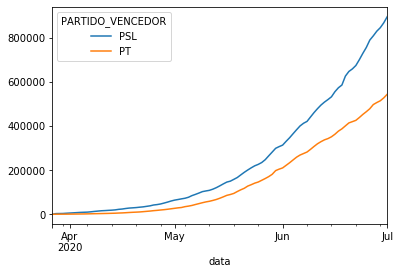

In [29]:
df_grouped_charts.pivot(index='data', columns='PARTIDO_VENCEDOR', values='casosAcumulado').plot()

#### New cases by day

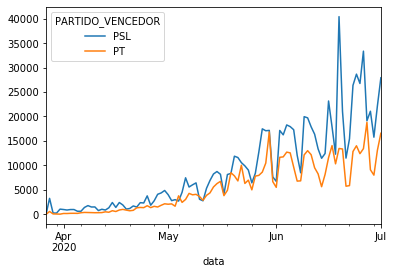

In [30]:
df_grouped_charts.pivot(index='data', columns='PARTIDO_VENCEDOR', values='casosNovos').plot()